In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os


**Load DataSets:    Teams,    Batting,    Pitching,     Fielding**


In [2]:
teams = pd.read_csv('/kaggle/input/baseball-databank/Teams.csv')
batting = pd.read_csv('/kaggle/input/baseball-databank/Batting.csv')
pitching = pd.read_csv('/kaggle/input/baseball-databank/Pitching.csv')
fielding = pd.read_csv('/kaggle/input/baseball-databank/Fielding.csv')

**Collect all important statitics from each dataset by team and year**

In [3]:
# Filter the data to include only records from 1962 onwards as 162 game seasons started then
teams = teams[teams['yearID'] >= 1962]
batting = batting[batting['yearID'] >= 1962]
pitching = pitching[pitching['yearID'] >= 1962]
fielding = fielding[fielding['yearID'] >= 1962]

# Completed Batting || all necessary stats -> Just have to clean up on the backend when putting it into teams
team_batting = batting.groupby(['teamID', 'yearID']).agg({
    'H': 'sum',
    'AB': 'sum',
    'HR': 'sum',
    'RBI': 'sum',
    'R':'sum', 
    'SO':'sum',
    'BB':'sum',
    'SB': 'sum'
    
}).reset_index()
team_batting['batting_avg'] = team_batting['H'] / team_batting['AB']

# Completed Pitching || all necessary stats -> Just have to clean up on the backend when putting it into teams
team_pitching = pitching.groupby(['teamID', 'yearID']).agg({
    'ER': 'sum',   # Earned Runs
    'IPouts': 'sum',  # Outs pitched (used for ERA calculation)
    'SO': 'sum',  # Strikeouts
    'BB': 'sum',  # Walks
    'H': 'sum',    # Hits allowed
    'SV': 'sum',   #Saves
    'HR': 'sum'    #HRs allowed
}).reset_index()
team_pitching['ERA'] = (team_pitching['ER'] * 9) / (team_pitching['IPouts'] / 3)

# Completed Fielding || all necessary stats -> Just have to clean up on the backend when putting it into teams
team_fielding = fielding.groupby(['teamID', 'yearID']).agg({
    'E': 'sum',   # Errors
    'DP': 'sum',  # Double Plays
    'PO':'sum',  #PutOuts
    'A': 'sum'   # Assists
}).reset_index()


**Creating dataset with Aggregated Individual Player stats**

In [4]:
Players_teams = teams.copy()
Players_teams = Players_teams[(Players_teams['G'] >= 161) & (Players_teams['G'] <= 163)]

Players_teams = Players_teams.merge(team_batting, on=['teamID', 'yearID'], how='left', suffixes=('', '_batting'))
Players_teams = Players_teams.merge(team_pitching, on=['teamID', 'yearID'], how='left', suffixes=('', '_pitching'))
Players_teams = Players_teams.merge(team_fielding, on=['teamID', 'yearID'], how='left', suffixes=('', '_fielding'))
# Players_teams = Players_teams.merge(team_batting[['teamID', 'yearID', 'batting_avg']], on=['teamID', 'yearID'], how='left')

Players_teams = Players_teams.drop(columns=['lgID', 'franchID','divID','Rank','Ghome','L','DivWin','WCWin','WSWin','LgWin','name','park','attendance','teamIDBR','teamIDlahman45','teamIDretro','R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'BPF', 'PPF'])

Players_teams = Players_teams.drop(columns=['yearID','teamID'])

Players_teams = Players_teams.dropna()

# print(Players_teams.columns.tolist())
# print(Players_teams.head())

**Because I just realized the teams dataset had most of the things I was aggregating from the individual datasets we are gonna try to make the model with just that first. May circle back and see if accuracy improves with other statistics as well.**

In [5]:

# Ensure only records within 161-163 games remain
teams = teams[(teams['G'] >= 161) & (teams['G'] <= 163)]

#!!!!Once everything is tested try including the losses column to see if it can get 100% accuracy.
teams = teams.merge(team_batting[['teamID', 'yearID', 'batting_avg']], on=['teamID', 'yearID'], how='left')

teams = teams.drop(columns=['yearID','teamID'])

teams = teams.drop(columns=['lgID', 'franchID','divID','Rank','Ghome','L','DivWin','WCWin','WSWin','LgWin','name','park','attendance','teamIDBR','teamIDlahman45','teamIDretro'])

teams = teams.dropna()

print(teams.columns.tolist())
print(teams.head())

['G', 'W', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'BPF', 'PPF', 'batting_avg']
       G   W    R    AB     H   2B  3B   HR   BB      SO  ...    HA  HRA  BBA  \
796  162  82  864  5628  1574  309  34  236  608  1024.0  ...  1534  228  662   
797  162  85  792  5527  1466  282  44  179  535   975.0  ...  1441  190  500   
798  162  95  810  5489  1490  274  26  179  595  1010.0  ...  1428  165  484   
799  162  74  794  5549  1508  310  22  184  558   900.0  ...  1547  202  665   
800  162  85  792  5630  1503  316  32  167  611  1019.0  ...  1433  173  498   

      SOA    E     DP     FP  BPF  PPF  batting_avg  
796   846  134  182.0  0.978  102  103     0.279673  
797  1220  107  138.0  0.982  105  103     0.265243  
798  1093  129  138.0  0.979  101   99     0.271452  
799  1017  116  151.0  0.981   95   96     0.271761  
800  1121  109  120.0  0.982  104  103  

**Simple Linear regression Model, see accuracy score and what stats influence the wins the most**

In [6]:
from sklearn.model_selection import train_test_split

# X = teams.drop(columns=['W','G'])
X = teams[['ERA','FP','batting_avg','R','HR','BB','HRA','BBA','DP','SV','CG','RA']]
y = teams['W']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_test, y_test)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

y_pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R²:', r2_score(y_test, y_pred))

# Check model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)


RMSE: 2.8063642865167995
R²: 0.940922732667373
             Coefficient
ERA            -0.654117
FP            112.534844
batting_avg    24.323477
R               0.076762
HR              0.024799
BB              0.007162
HRA            -0.033624
BBA            -0.006593
DP             -0.010931
SV              0.428701
CG              0.115379
RA             -0.065481


**Random Forest Regressor**

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f'Random Forest RMSE: {rf_rmse}')
print(f'Random Forest R²: {rf_r2}')


Random Forest RMSE: 3.94385812847014
Random Forest R²: 0.8833257880756863


**K-Means Clustering**

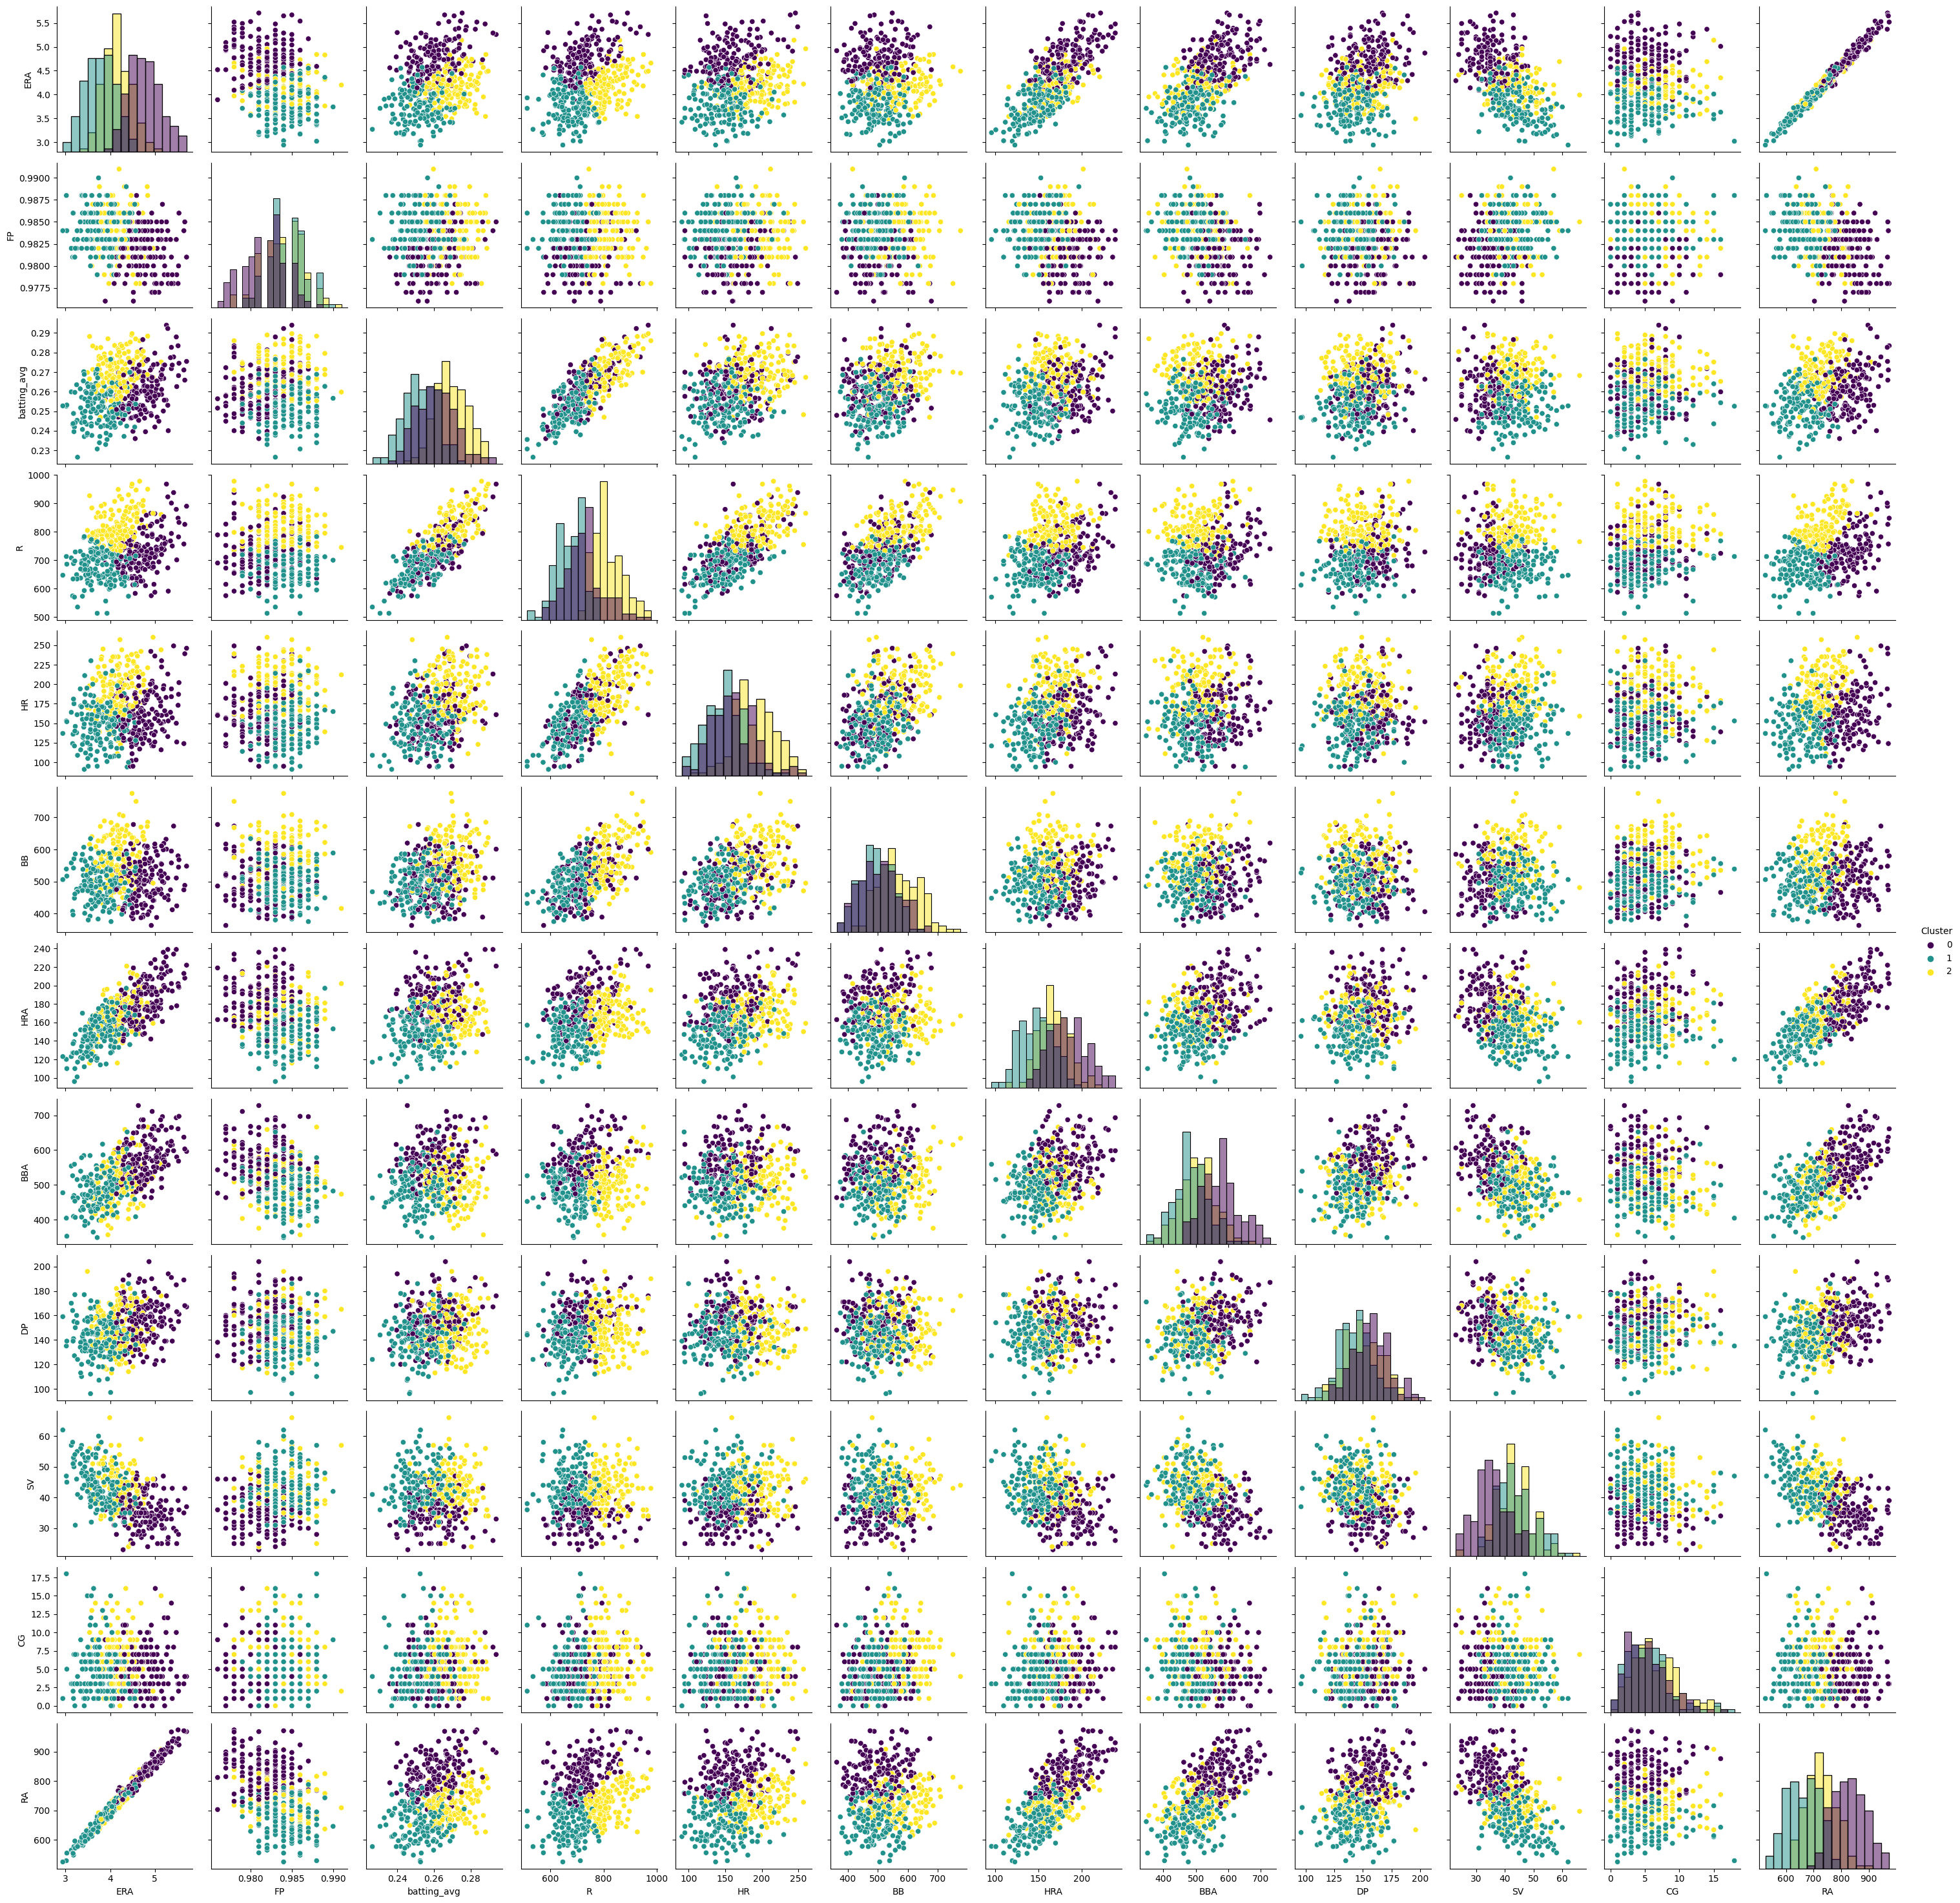

Cluster feature means:
              ERA        FP  batting_avg           R          HR          BB  \
Cluster                                                                        
0        4.775759  0.981608     0.261141  728.265823  161.481013  503.601266   
1        3.772375  0.984219     0.252476  673.018750  147.468750  493.800000   
2        4.167840  0.983895     0.269758  816.228395  190.703704  568.833333   

                HRA         BBA          DP         SV        CG          RA  
Cluster                                                                       
0        184.721519  575.170886  156.702532  35.221519  4.841772  829.525316  
1        147.743750  485.925000  141.975000  43.850000  4.962500  662.537500  
2        167.765432  506.808642  149.493827  43.382716  6.123457  727.820988  
Linear Regression RMSE: 2.9423842581330937
Linear Regression R²: 0.935057188611543
Random Forest RMSE: 3.9576553072810676
Random Forest R²: 0.8825080148559457


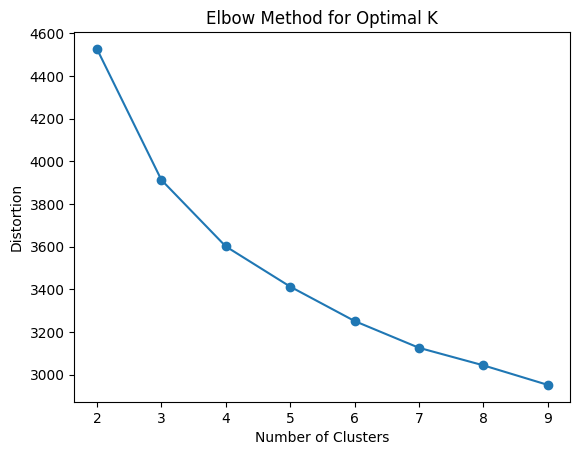

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Handle warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Temporarily suppress warnings for clarity

# Features for clustering
clustering_features = ['ERA', 'FP', 'batting_avg', 'R', 'HR', 'BB', 
                       'HRA', 'BBA', 'DP', 'SV', 'CG', 'RA']

# Handle missing or infinite values
teams.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
teams.dropna(inplace=True)  # Drop rows with NaN (or use .fillna() if you want to impute)

# Scale the features for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(teams[clustering_features])

# Apply K-Means clustering (set `n_init` explicitly)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
teams['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
sns.pairplot(teams, hue='Cluster', vars=clustering_features, palette='viridis', diag_kind='hist')
plt.show()

# Analyze cluster characteristics
cluster_means = teams.groupby('Cluster')[clustering_features].mean()
print("Cluster feature means:")
print(cluster_means)

# Add clusters to regression features
X = teams[['ERA', 'FP', 'batting_avg', 'R', 'HR', 'BB', 'HRA', 'BBA', 'DP', 'SV', 'CG', 'RA', 'Cluster']]
y = teams['W']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

linear_rmse = mean_squared_error(y_test, y_pred_linear, squared=False)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression RMSE: {linear_rmse}")
print(f"Linear Regression R²: {linear_r2}")

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R²: {rf_r2}")

# Optional: Find the optimal number of clusters using the Elbow Method
distortions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Explicitly set `n_init`
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 10), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()
